In [1]:
from collections import defaultdict

import numpy as np
import tensorflow as tf
from skimage.metrics import structural_similarity
from tqdm import tqdm

from virvs.architectures.pix2pix import Generator
from virvs.data.npy_dataloader import NpyDataloader
from virvs.utils.metrics_utils import calculate_metrics

import tifffile as tif

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from virvs.architectures.pix2pix import Generator
from virvs.data.npy_dataloader import NpyDataloader

tf.keras.utils.set_random_seed(42)


BASE_PATH = "/home/wyrzyk93/VIRVS/outputs/weights/"
DATASETS = {
    "hadv_2ch": "/bigdata/casus/MLID/maria/VIRVS_data/HADV/processed/test",
    "hadv_1ch": "/bigdata/casus/MLID/maria/VIRVS_data/HADV/processed/test",
    "vacv": "/bigdata/casus/MLID/maria/VIRVS_data/VACV/processed/test",
    "iav": "/bigdata/casus/MLID/maria/VIRVS_data/IAV/processed/test",
    "hsv": "/bigdata/casus/MLID/maria/VIRVS_data/HSV/processed/test",
    "rv": "/bigdata/casus/MLID/maria/VIRVS_data/RV/processed/test",
}

WEIGHTS = {
    "pix2pix": {
        "hadv_2ch": "model_100000_316674a2-4299-4a06-b601-5e20f7dd02a6.h5",
        "hadv_1ch": "model_100000_d6792b38-8091-448d-a26a-ef08375b8dbe.h5",
        "vacv": "model_100000_138fd26a-88b9-4d2a-9f96-6a2ffe991364.h5",
        "iav": "model_100000_ef994584-7730-41b9-9a56-75d478bacf02.h5",
        "hsv": "model_100000_52d604f6-25fe-4d42-a212-cef281e3a8b5.h5",
        "rv": "model_100000_a6bd97a2-d889-40a4-a8ec-5c8816797f9d.h5",
    },
    "unet": {
        "hadv_2ch": "model_100000_c0175f01-1e6e-4bec-9f2e-2e5542c16584.h5",
        "hadv_1ch": "model_100000_47b9346c-e143-4bf7-9dce-40aa6f2329e5.h5",
        "vacv": "model_100000_4f91526f-a1b4-4057-926e-073f4ffbef67.h5",
        "iav": "model_100000_26c5b8b9-0c35-4fee-9eac-44a857cebe76.h5",
        "hsv": "model_100000_1b8e6e99-10fa-4221-b53a-b680a65826be.h5",
        "rv": "model_100000_0ca537f4-cbd8-4722-89cb-bdd43107a66b.h5",
    },
}


2024-08-19 13:30:53.842340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 13:30:53.842430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 13:30:54.296833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 13:30:55.320821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 13:31:11.837863: W tensorflow/comp

Data shape: (12, 5948, 6048, 1)


2024-08-19 13:31:52.680680: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


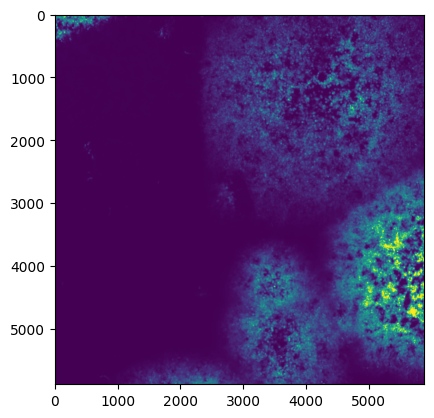

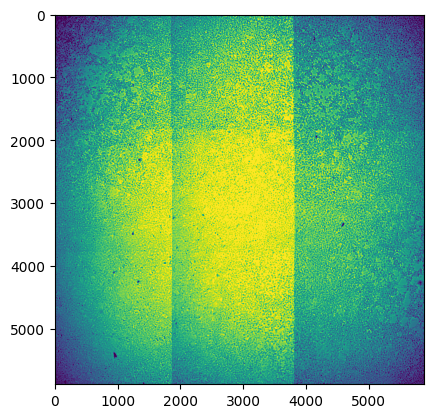

<Figure size 640x480 with 0 Axes>

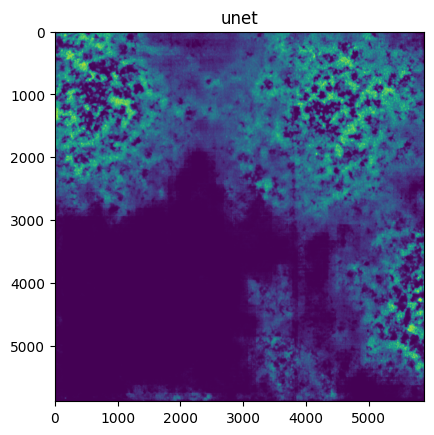

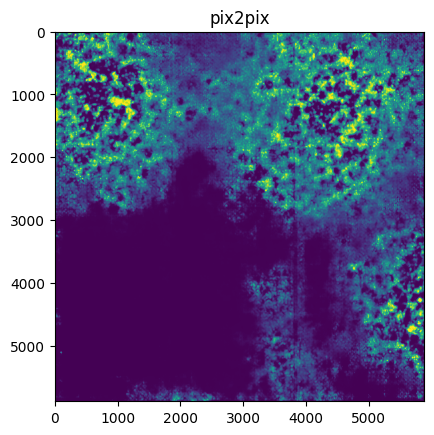

In [2]:
for virus in ["vacv"]:

    if "vacv" == virus:
        size = 5888
    else:
        size = 2048

    if "2ch" in virus:
        ch_in = [0, 1]
    else:
        ch_in = [0]
        
    dataloader = NpyDataloader(
        path=DATASETS[virus],
        im_size=size,
        random_jitter=False,
        crop_type="center",
        ch_in=ch_in,
    )
    # the highest bg 
    x, y = dataloader[10]
 
    plt.imshow(np.squeeze(y), vmin=-1, vmax=1)
    plt.figure()

    plt.imshow(np.squeeze(x[..., 0]), vmin=-1, vmax=1)
    plt.figure()        
    
    for model in ["unet", "pix2pix"]:
        if model == "unet":
            dropout = False
        else:
            dropout = True
        generator = Generator(size, ch_in=ch_in, ch_out=1, apply_dropout=dropout)
        generator.load_weights(f"{BASE_PATH}/{WEIGHTS[model][virus]}")
        output = np.squeeze(generator(np.expand_dims(x, 0), training=True), 0)
        
        plt.figure()
        plt.imshow(np.squeeze(output), vmin=-1, vmax=1)
        plt.title(model)

        plt.imsave(f"output_{model}.svg", np.squeeze(output), format="svg", vmin=-1, vmax=1)
plt.imsave("x.svg", np.squeeze(x) , format="svg", vmin=-1, vmax=1)
plt.imsave("y.svg", np.squeeze(y), format="svg", vmin=-1, vmax=1)

In [17]:
from os import listdir
from os.path import isfile, join
path = "/bigdata/casus/MLID/maria/VIRVS_data/VACV/processed/test"
filenames = [f for f in listdir(join(path, "x")) if isfile(join(path, "x", f))]
print(filenames[10])

121218-AY-JM-VACV-TC_C04_t115.tif


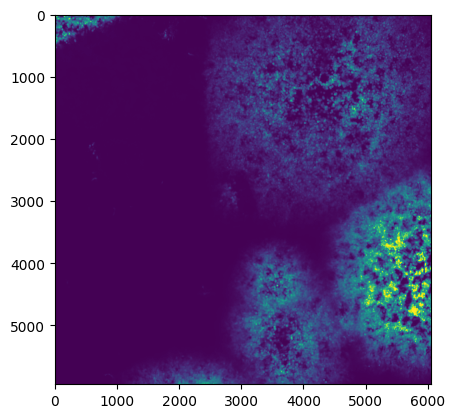

In [10]:
import tifffile as tif

x_115 = tif.imread("/bigdata/casus/MLID/maria/VIRVS_data/VACV/processed/test/gt/121218-AY-JM-VACV-TC_C04_t115.tif")
plt.imshow(x_115)

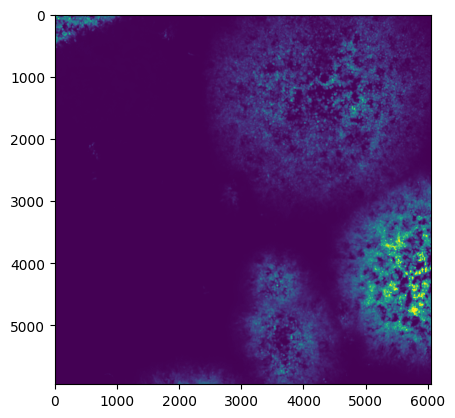

In [11]:
x_108 = tif.imread("/bigdata/casus/MLID/maria/VIRVS_data/VACV/processed/test/gt/121218-AY-JM-VACV-TC_C04_t108.tif")
plt.imshow(x_108)